In [1]:
import pandas as pd
from datetime import datetime
import networkx as nx
import itertools
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import copy

import osmnx as ox
import igraph as ig

In [2]:
with open("./graph_networkx_SOUTHAMERICA_msc_route.pkl", 'rb') as f:  # notice the r instead of w
    G_loaded = pickle.load(f)
    G = copy.deepcopy(G_loaded)

### Plot based on longitude, latitude

In [7]:
f = open("data_av/msc_route_country_port_codes.json")
dict_ports = json.load(f)

In [8]:
#Plot nodes based on location
for node, attributes in G.nodes(data=True):
    try:
        attributes["latitude"] = dict_ports[node]["LocationLatitude"]
        attributes["longitude"] = dict_ports[node]["LocationLongitude"]
    except KeyError:
        raise Warning("Port {0} cannot be found".format(node))
        
position_ports = {k: (attr["longitude"], attr["latitude"]) for k, attr in G.nodes(data=True)}

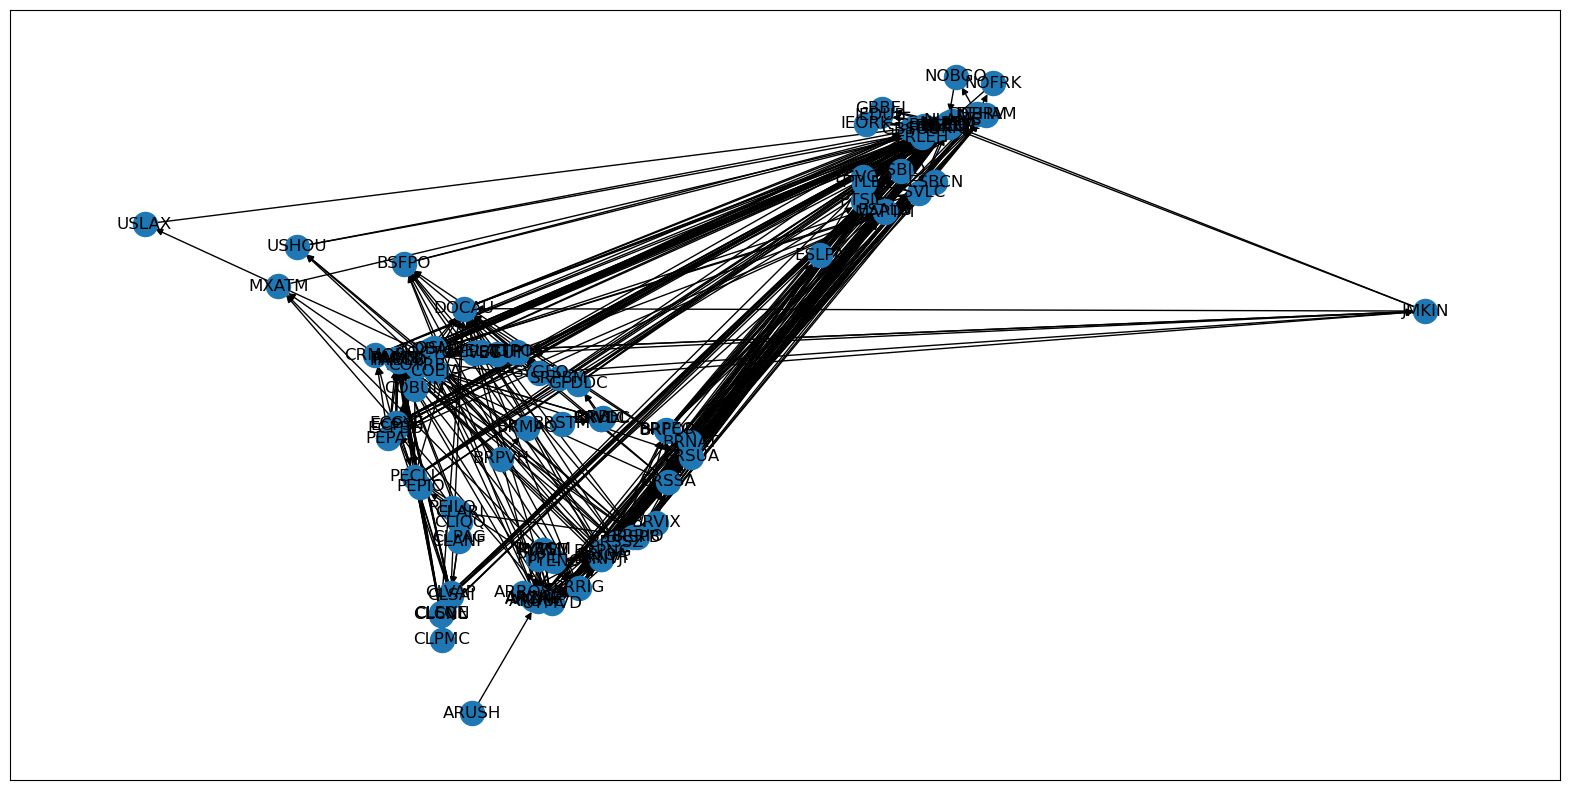

In [9]:
plt.figure(figsize=(20,10))
nx.draw_networkx(G, pos=position_ports)
# plt.savefig("./figure/geo_SA_msc_route.png")

In [8]:
#Unweighted shortest-path now -- all edges are 1
#Normalized is True -- so normalized for directed graph
nx.betweenness_centrality(G)

{'ARBUE': 0.02011209300770704,
 'BRRIO': 0.017597018088809816,
 'BEANR': 0.030918846574212098,
 'UYMVD': 0.039822581716858846,
 'NLRTM': 0.05487863738857807,
 'GBLGP': 0.0034170577824672956,
 'DEBRV': 0.0052525252525252525,
 'PACTB': 0.006477232910507986,
 'BRRIG': 0.032578122494996316,
 'MAPTM': 0.004094114030915632,
 'PTLEI': 0.00014499492277270052,
 'DEHAM': 0.0,
 'ESLPA': 0.003935339489232308,
 'IEORK': 0.0,
 'ESVLC': 0.006778741680228083,
 'BEZEE': 0.0026814632656135917,
 'COCTG': 0.05266528735714924,
 'DOCAU': 0.006185081466712011,
 'FRDKK': 0.0009761308650197537,
 'NLAMS': 0.0,
 'NLMOE': 0.0,
 'ARZAE': 0.00023140495867768595,
 'BRSSA': 0.008665409935017776,
 'NLVLI': 0.0013044517211183875,
 'ARCMP': 0.0,
 'ARROS': 0.00013997113997113998,
 'ARUSH': 0.0,
 'BRBEL': 0.0,
 'BRVDC': 0.0018518518518518517,
 'BRIOA': 0.0030709985861501012,
 'BRMAO': 0.0018181818181818182,
 'BRNVT': 0.0,
 'BRPEC': 0.007063279857397504,
 'BRSSZ': 0.01070327094294376,
 'BRPNG': 0.003961366736135295,
 'BRPV

# Analyze the edges 

In [9]:
#Add frequency of the duplicates
for edge in G.edges(data=True):
    etd = edge[2]["etd_origin"]
    eta = edge[2]["eta_destination"]
    time = edge[2]["time_minutes"]
    
    combine = []
    for (o, d, t) in zip(etd, eta, time):
        combine.append((o, d, t))
        
    freq = {}
    for i in combine:
        freq[i] = combine.count(i)
        
    median_time_minutes = np.median([k[2] for k,v in freq.items()])

    G.edges[edge[0], edge[1]]["frequency"] = freq
    G.edges[edge[0], edge[1]]["median_time_minutes"] = median_time_minutes

C:\Users\IvS\AppData\Local\Temp\ipykernel_24572\190393763.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(4,4))


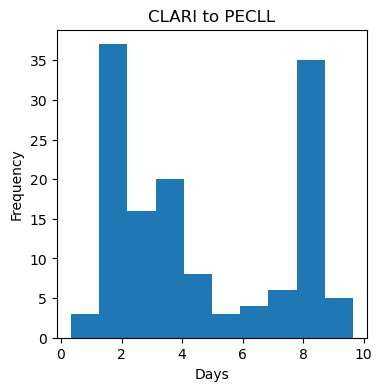

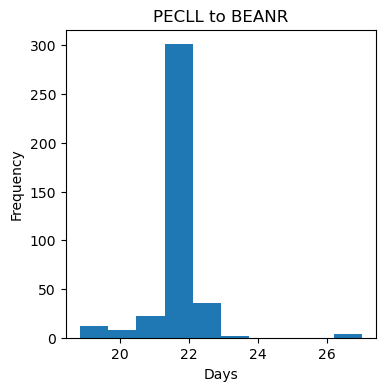

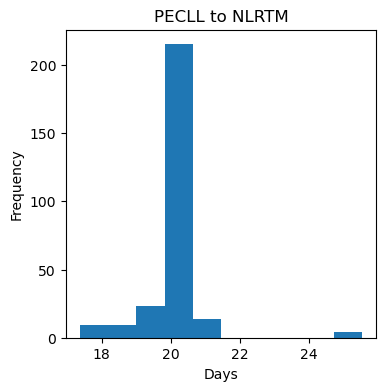

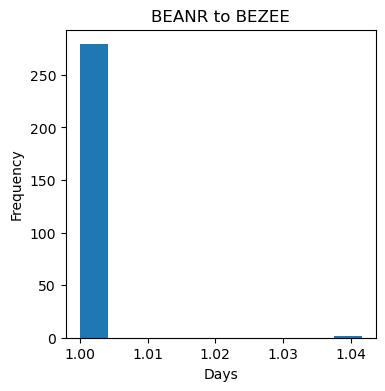

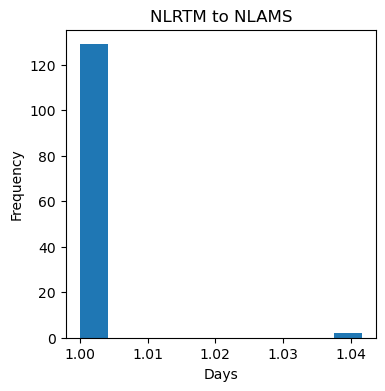

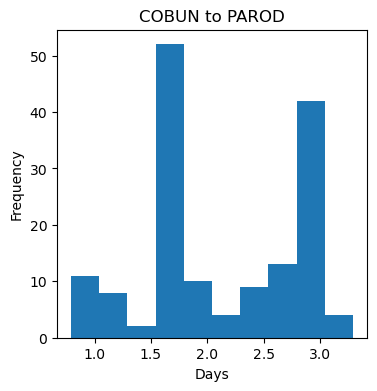

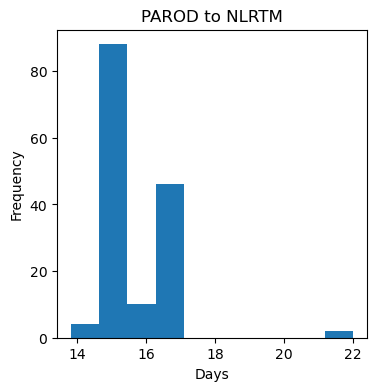

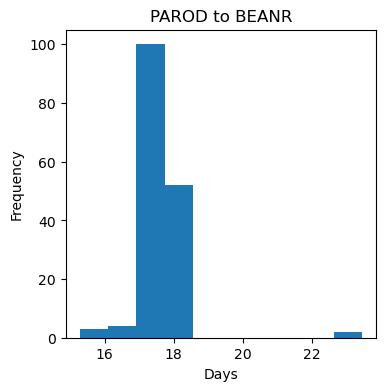

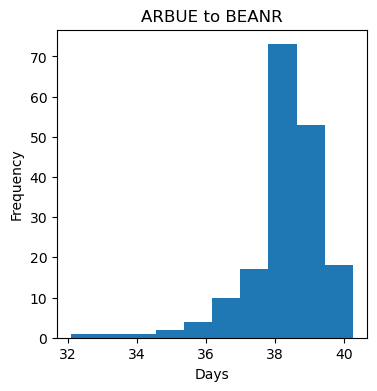

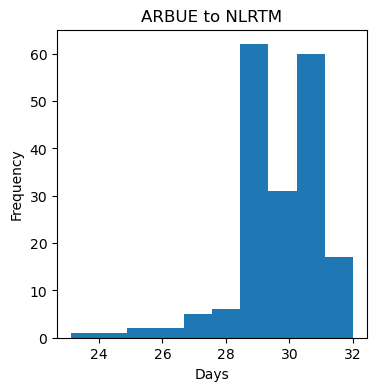

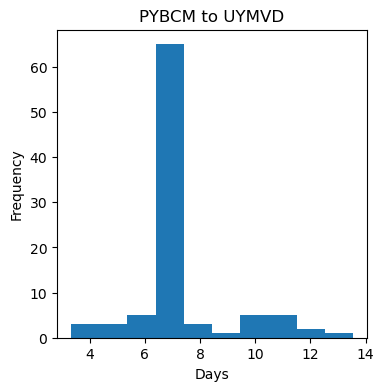

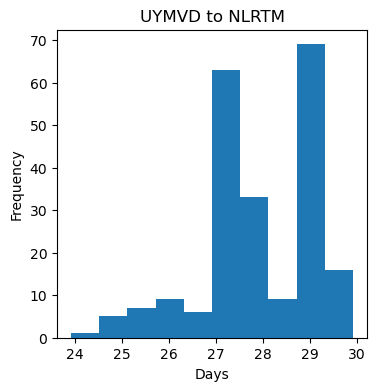

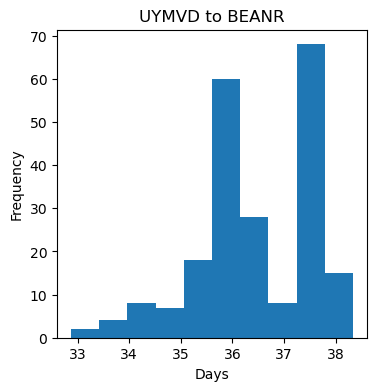

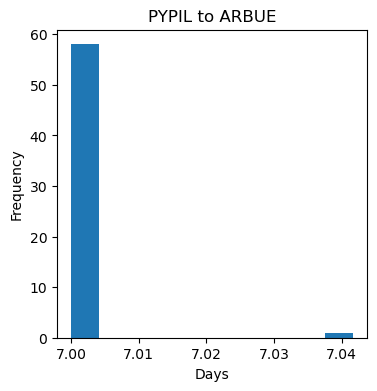

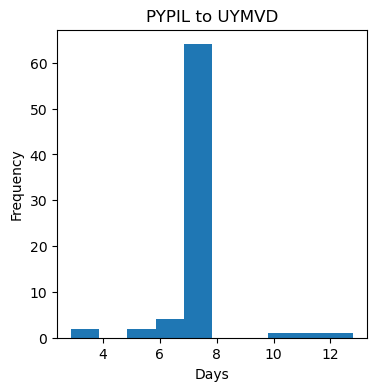

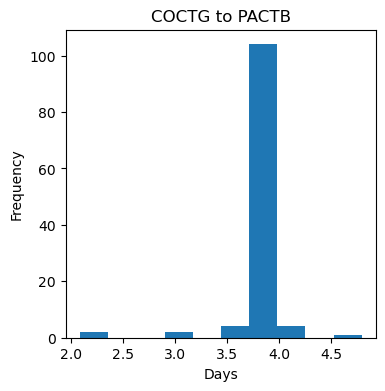

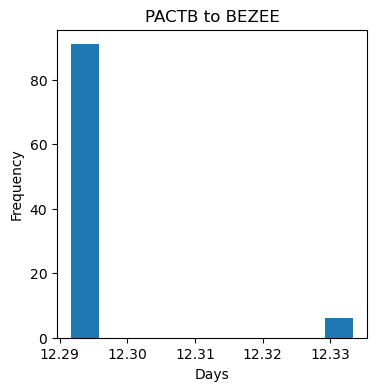

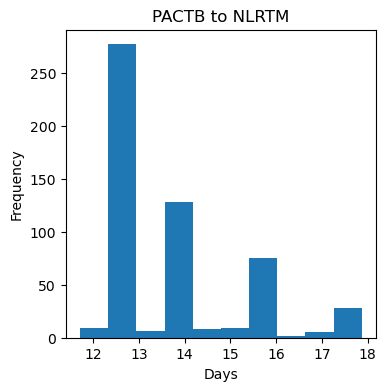

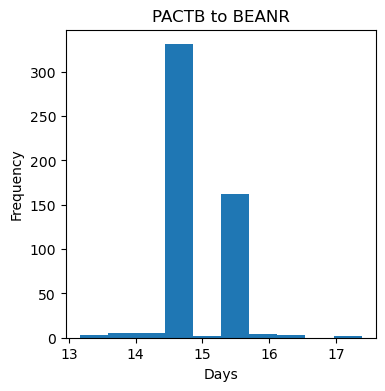

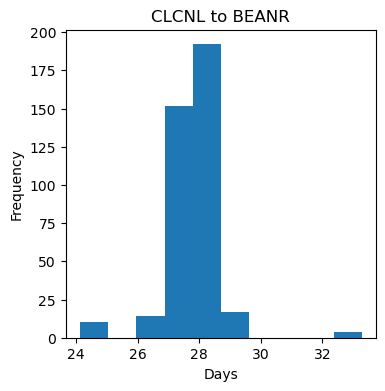

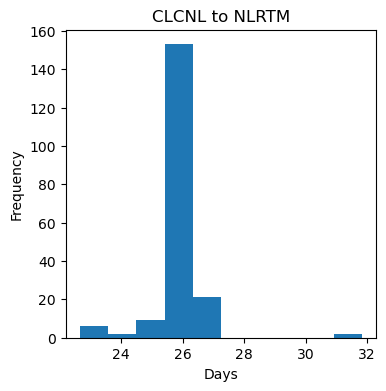

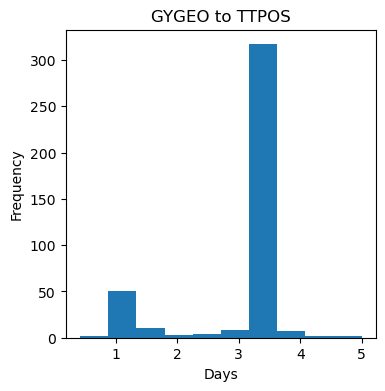

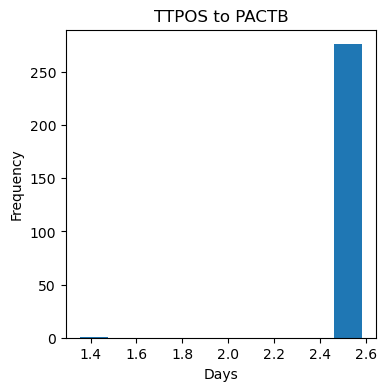

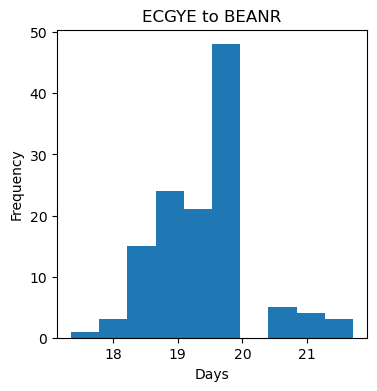

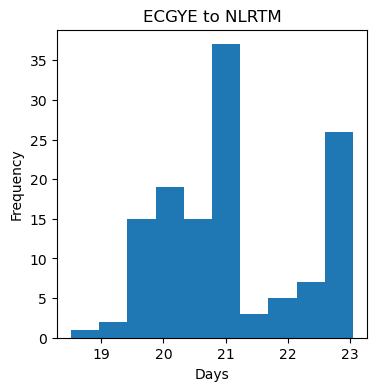

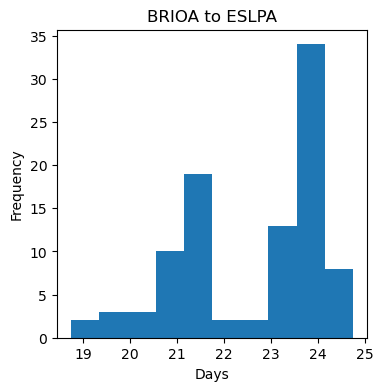

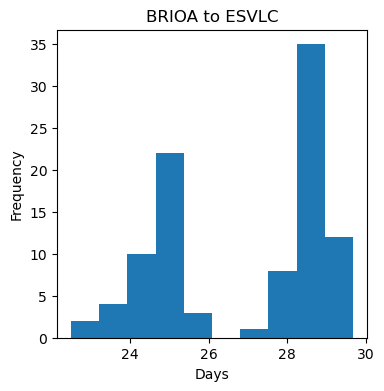

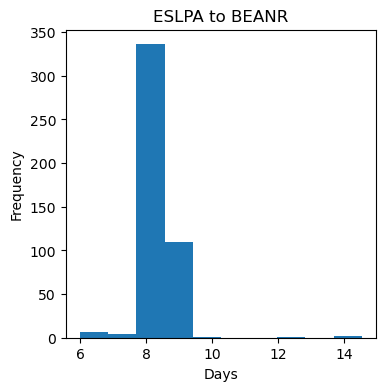

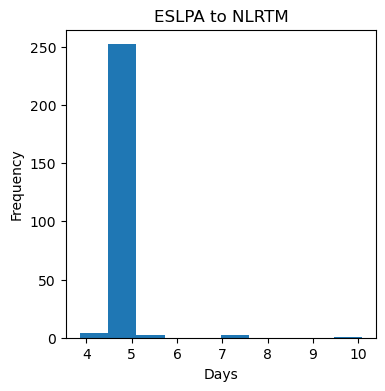

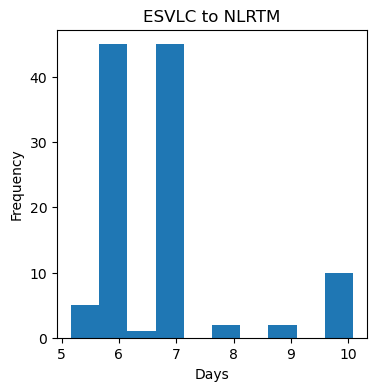

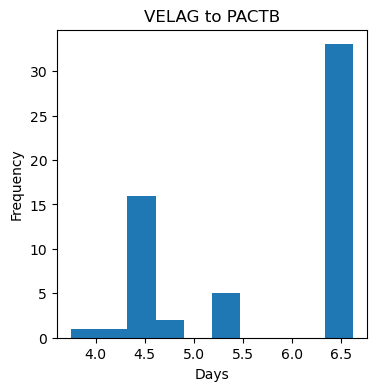

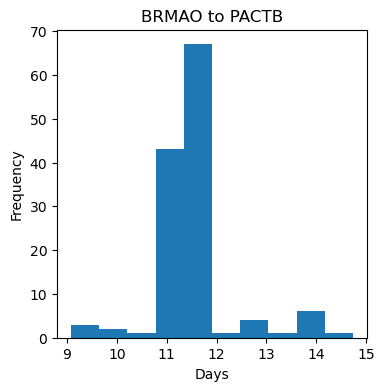

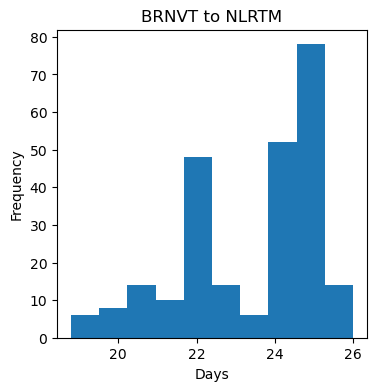

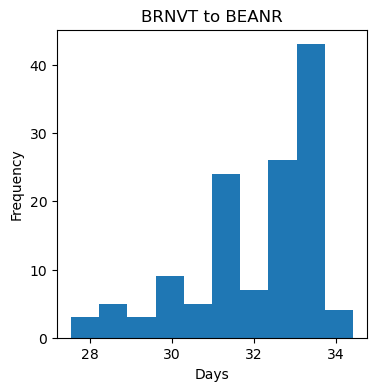

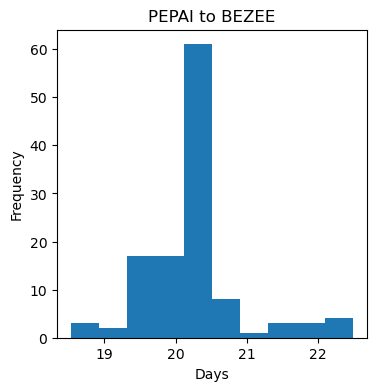

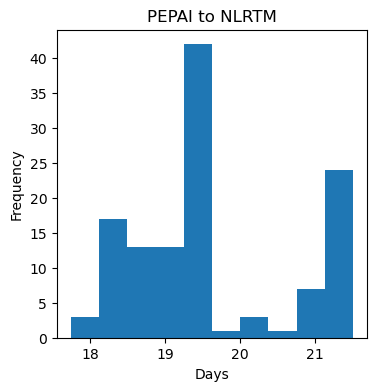

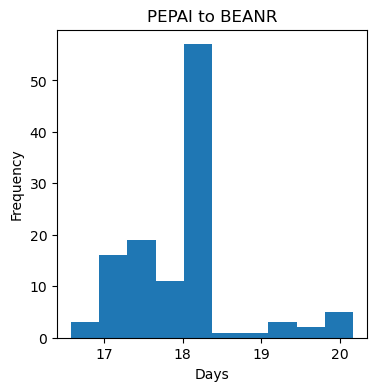

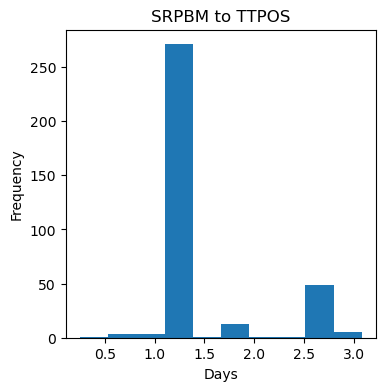

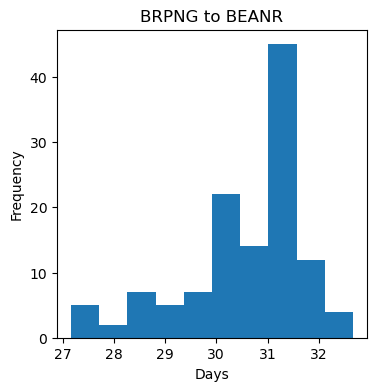

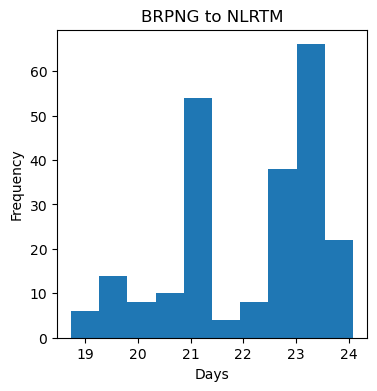

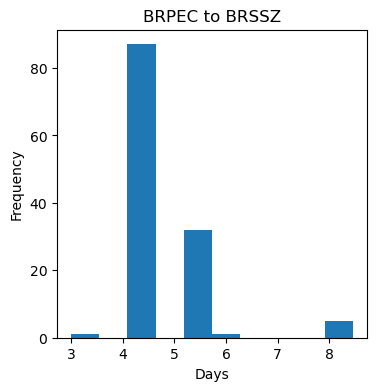

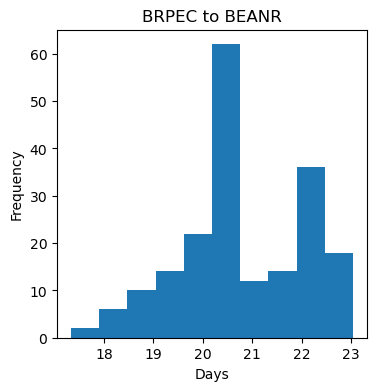

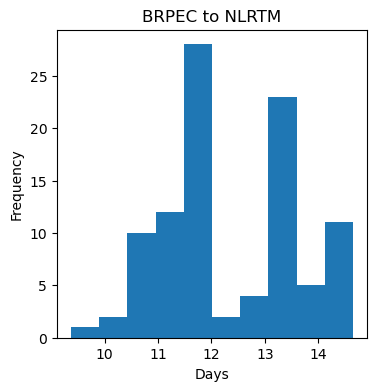

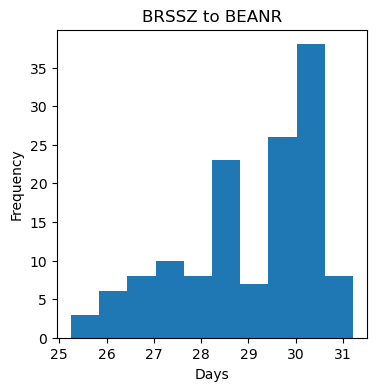

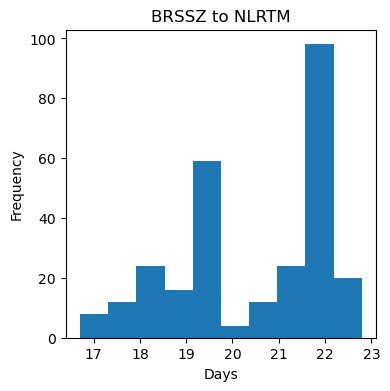

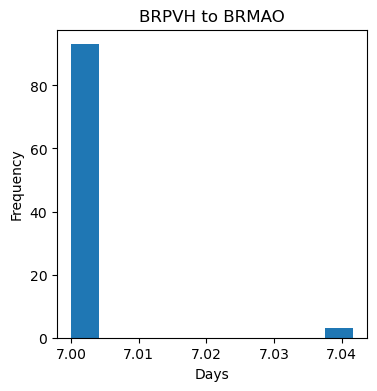

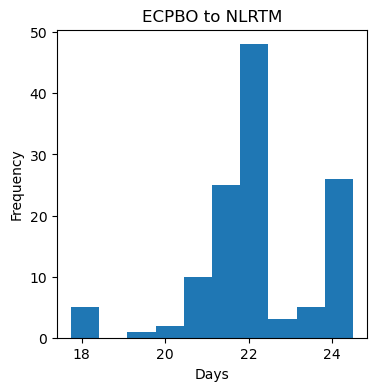

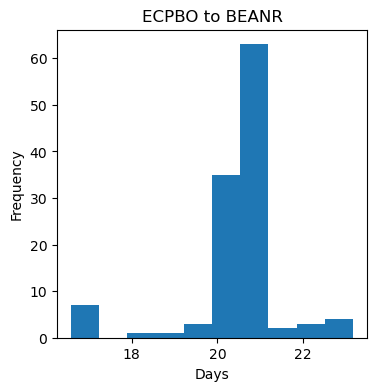

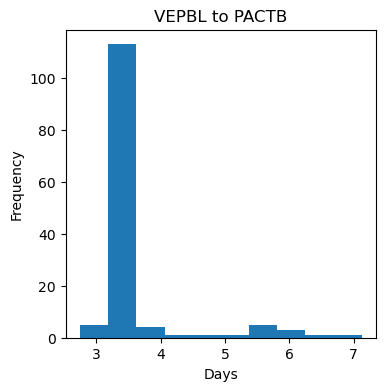

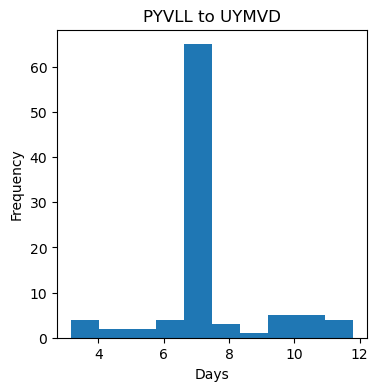

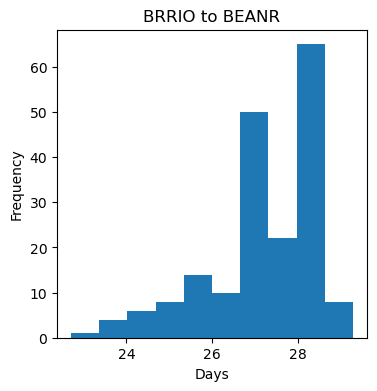

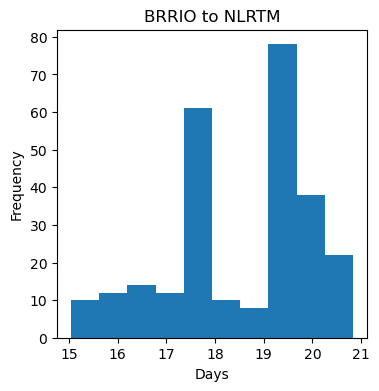

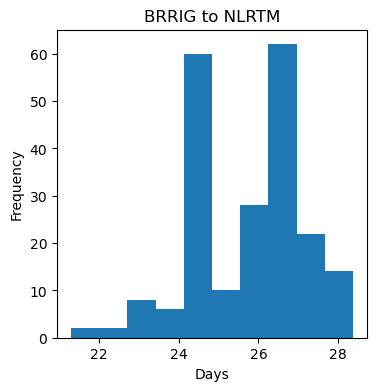

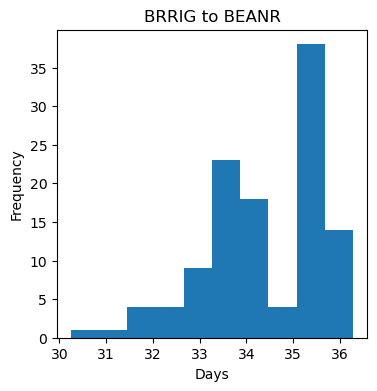

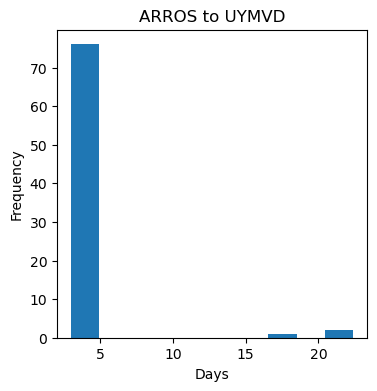

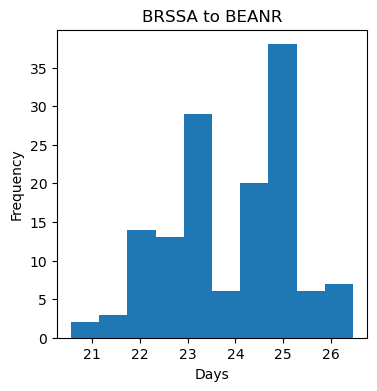

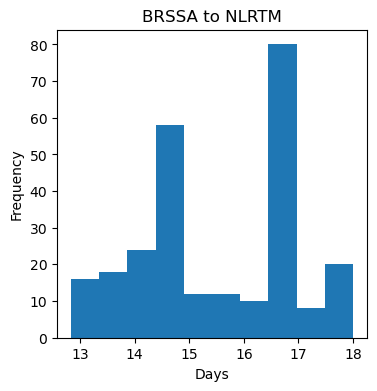

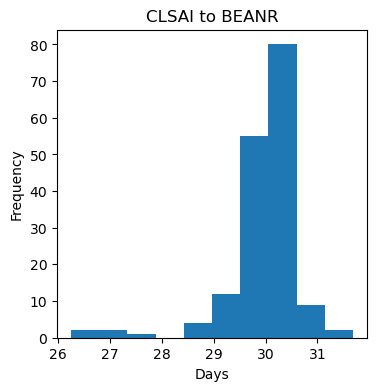

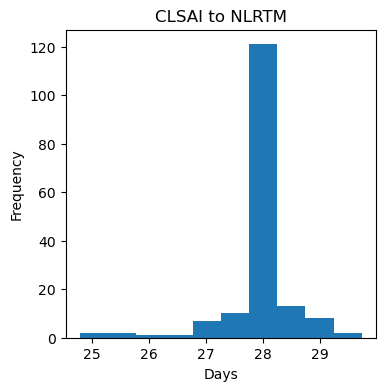

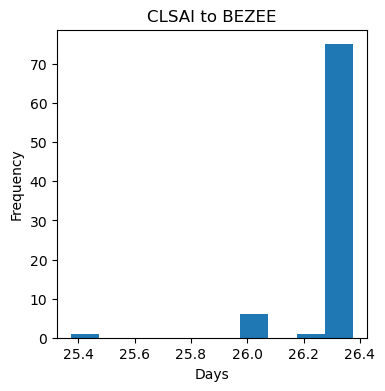

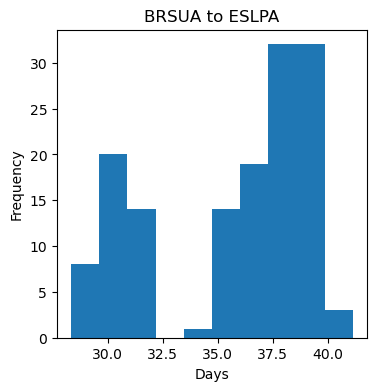

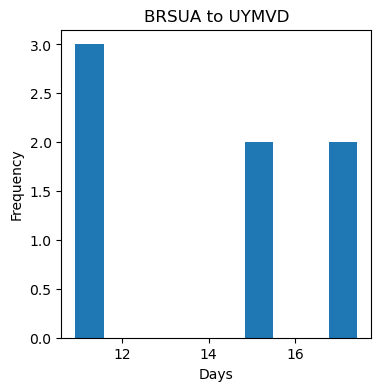

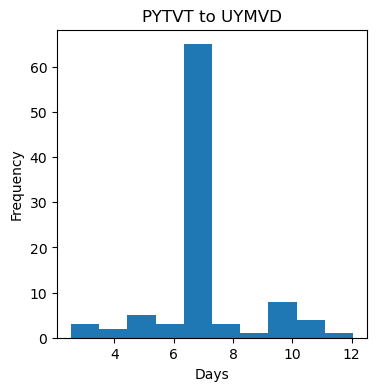

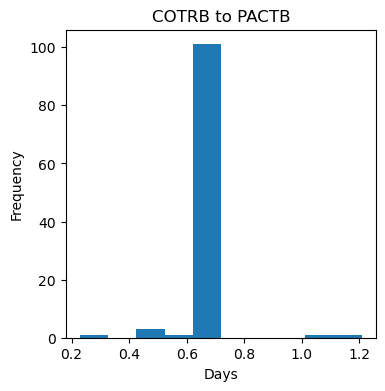

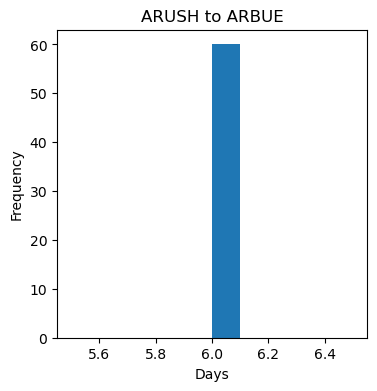

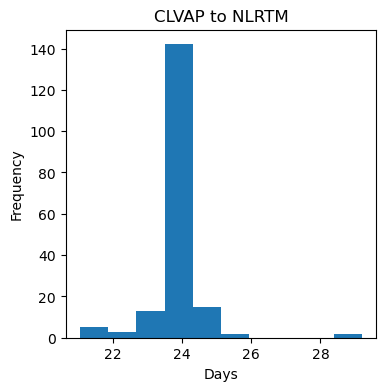

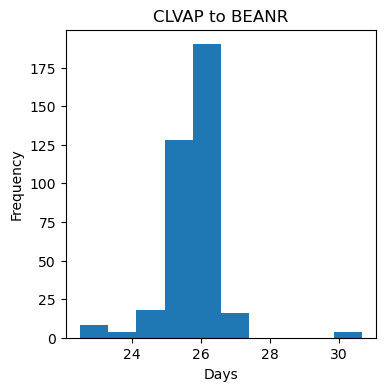

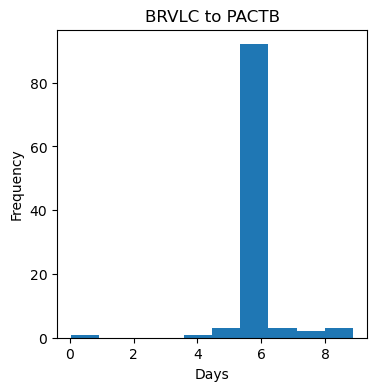

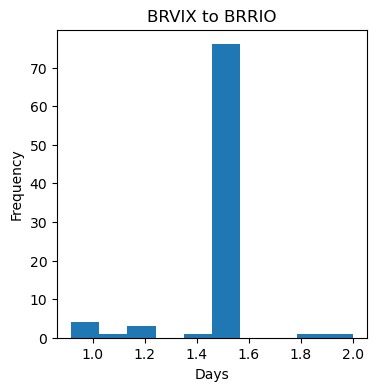

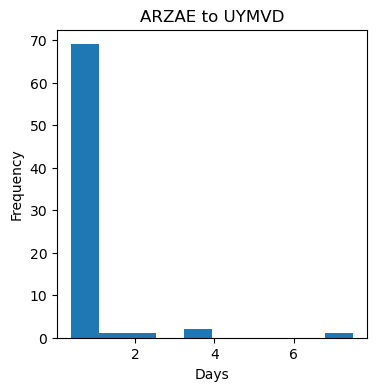

In [8]:
for edge in G.edges(data=True):
    plt.figure(figsize=(4,4))
    plt.title(edge[0] + " to " + edge[1])
    plt.ylabel("Frequency")
    plt.xlabel("Days")
    #plt.hist([e/60/24 for e in edge[2]["time_minutes"]])
    plt.hist([k[2]/60/24 for k, v in edge[2]["frequency"].items()])

# Plot with Plotly

In [10]:
import plotly.graph_objects as go

In [11]:
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = (G.nodes[edge[0]]['longitude'], G.nodes[edge[0]]['latitude'])
    x1, y1 = (G.nodes[edge[1]]['longitude'], G.nodes[edge[1]]['latitude'])
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = (G.nodes[node]['longitude'], G.nodes[node]['latitude'])
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

In [12]:
node_adjacencies = []
node_text = []
for n, attributes in G.nodes(data=True):
    node_text.append(("Port UN Code: "+ str(n) + "\r\n Location: " + "(" + str(attributes["longitude"]) + "," + str(attributes["latitude"]) + ")"))

for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('# of connections: '+str(len(adjacencies[1])))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

In [13]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>International shipping routes: MSC',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
#                 annotations=[ dict(
#                     text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
#                     showarrow=False,
#                     xref="paper", yref="paper",
#                     x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

## Calculate Betweenness with igraph

In [14]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, Normalize

In [15]:
ig_G = ig.Graph.from_networkx(G)

In [16]:
def plot_betweenness(g, vertex_betweenness, edge_betweenness, ax, cax1, cax2):
    '''Plot vertex/edge betweenness, with colorbars

    Args:
        g: the graph to plot.
        ax: the Axes for the graph
        cax1: the Axes for the vertex betweenness colorbar
        cax2: the Axes for the edge betweenness colorbar
    '''

    # Rescale betweenness to be between 0.0 and 1.0
    scaled_vertex_betweenness = ig.rescale(vertex_betweenness, clamp=True)
    scaled_edge_betweenness = ig.rescale(edge_betweenness, clamp=True)
    print(f"vertices: {min(vertex_betweenness)} - {max(vertex_betweenness)}")
    print(f"edges: {min(edge_betweenness)} - {max(edge_betweenness)}")

    # Define mappings betweenness -> color
    cmap1 = LinearSegmentedColormap.from_list("vertex_cmap", ["pink", "indigo"])
    cmap2 = LinearSegmentedColormap.from_list("edge_cmap", ["lightblue", "midnightblue"])

    # Plot graph
    g.vs["color"] = [cmap1(betweenness) for betweenness in scaled_vertex_betweenness]
    g.vs["size"]  = ig.rescale(vertex_betweenness, (0.1, 0.5))
    g.vs["label"] = ig_G.vs.get_attribute_values('_nx_name')
    g.vs["label_size"] = 8
    g.es["color"] = [cmap2(betweenness) for betweenness in scaled_edge_betweenness]
    g.es["width"] = ig.rescale(edge_betweenness, (0.5, 1.0))
    
    # Set coordinates
    lat = g.vs.get_attribute_values('latitude')
    lon = g.vs.get_attribute_values("longitude")
    
    coords = []
    for la,lo in zip(lat, lon):
        c = (lo, la)
        coords.append(c)
        
    ig.plot(
        g,
        target=ax,
        layout="fruchterman_reingold", #coords
        vertex_frame_width=0.2,
    )

    # Color bars
    norm1 = ScalarMappable(norm=Normalize(0, max(vertex_betweenness)), cmap=cmap1)
    norm2 = ScalarMappable(norm=Normalize(0, max(edge_betweenness)), cmap=cmap2)
    plt.colorbar(norm1, cax=cax1, orientation="horizontal", label='Vertex Betweenness')
    plt.colorbar(norm2, cax=cax2, orientation="horizontal", label='Edge Betweenness')

Calculate betweenness without weights

In [17]:
#Unweighted shortest path now! 
vertex_betweenness1 = ig_G.betweenness()
edge_betweenness1 = ig_G.edge_betweenness()

In [18]:
centrality_df = pd.DataFrame(list(zip(ig_G.vs.get_attribute_values('_nx_name'), vertex_betweenness1, edge_betweenness1, ig_G.degree(mode="in"), 
                                      ig_G.degree(mode="out"), ig_G.degree(mode="all"), ig_G.closeness())),
              columns=['port',"betweenness", "edge_betweenness",'in_degree', 'out_degree', "sum_of_degrees", "closeness"])

In [19]:
centrality_df

port  betweenness  edge_betweenness  in_degree  out_degree  \
0    ARBUE   199.109721         33.601984          8          18   
1    BRRIO   174.210479         13.750000          9          17   
2    BEANR   306.096581          4.583333         51           8   
3    UYMVD   394.243559          7.625526         12          20   
4    NLRTM   543.298510          5.333860         52          11   
..     ...          ...               ...        ...         ...   
96   PYENO     0.000000          3.116667          0           5   
97   UYNVP     0.000000          8.973052          0           4   
98   NOBGO     0.000000          3.984293          1           1   
99   PEILQ    11.627381         29.321501          3           1   
100  ESBCN     0.000000          5.118383          1           1   

     sum_of_degrees  closeness  
0                26   0.540541  
1                26   0.552486  
2                59   0.671141  
3                32   0.558659  
4                63   0.689655  
..              ...        ...  
96                5   0.366300  
97                4   0.374532  
98                2   0.411523  
99                4   0.335570  
100               2   0.366300  

[101 rows x 7 columns]

vertices: 0.0 - 543.2985101469229
edges: 1.0 - 236.57195488721806


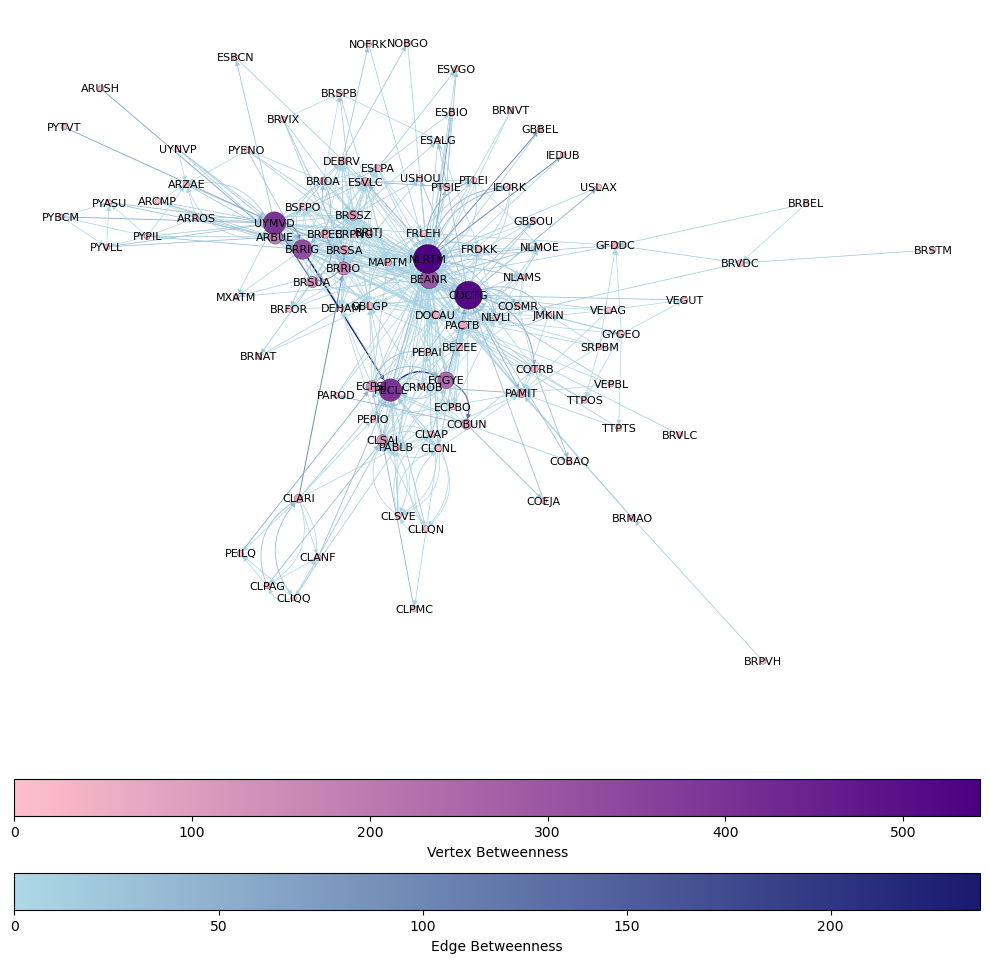

In [24]:
fig, axs = plt.subplots(
    3, 1,
    figsize=(10, 10),
    gridspec_kw=dict(height_ratios=(20, 1, 1)),
)
plot_betweenness(ig_G, vertex_betweenness1, edge_betweenness1, *axs)
#plot_betweenness(ig_G, vertex_betweenness1, edge_betweenness1, *axs[:, 1])
fig.tight_layout(h_pad=1)
# plt.savefig("./figure/betweenness_SA_msc_route.png")
plt.show()

Calculate betweenness with weights

In [25]:
#Centrality with weights
vertex_betweenness_weights = ig_G.betweenness(weights="median_time_minutes")
edge_betweenness_weights = ig_G.edge_betweenness(weights="median_time_minutes")

centrality_df_weights = pd.DataFrame(list(zip(ig_G.vs.get_attribute_values('_nx_name'), vertex_betweenness_weights, edge_betweenness_weights, ig_G.degree(mode="in"), 
                                      ig_G.degree(mode="out"), ig_G.degree(mode="all"), ig_G.closeness())),
              columns=['port',"betweenness", "edge_betweenness",'in_degree', 'out_degree', "sum_of_degrees", "closeness"])

In [26]:
centrality_df_weights

port  betweenness  edge_betweenness  in_degree  out_degree  \
0    ARBUE        195.0               0.0          8          18   
1    BRRIO        857.0               0.0          9          17   
2    BEANR        281.5               0.0         51           8   
3    UYMVD        181.0               0.0         12          20   
4    NLRTM        560.5               0.0         52          11   
..     ...          ...               ...        ...         ...   
96   PYENO          0.0               0.0          0           5   
97   UYNVP          0.0               0.0          0           4   
98   NOBGO          0.0               0.0          1           1   
99   PEILQ        120.0               0.0          3           1   
100  ESBCN          0.0               0.0          1           1   

     sum_of_degrees  closeness  
0                26   0.540541  
1                26   0.552486  
2                59   0.671141  
3                32   0.558659  
4                63   0.689655  
..              ...        ...  
96                5   0.366300  
97                4   0.374532  
98                2   0.411523  
99                4   0.335570  
100               2   0.366300  

[101 rows x 7 columns]

vertices: 0.0 - 860.0
edges: 0.0 - 628.0


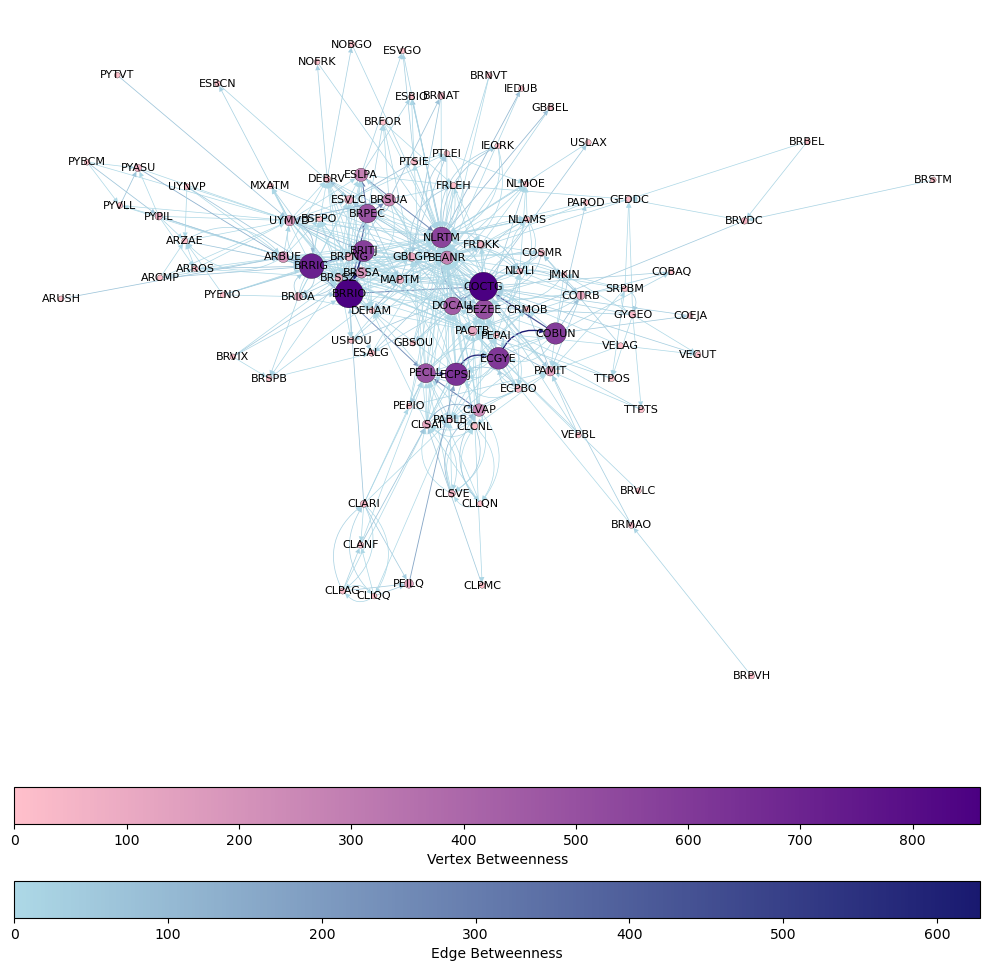

In [27]:
fig, axs = plt.subplots(
    3, 1,
    figsize=(10, 10),
    gridspec_kw=dict(height_ratios=(20, 1, 1)),
)
plot_betweenness(ig_G, vertex_betweenness_weights, edge_betweenness_weights, *axs)
fig.tight_layout(h_pad=1)
# plt.savefig("./figure/betweenness_weights_SA_msc_route.png")
plt.show()

Plot degree

In [28]:
def plot_degree(g, degree, title, ax, cax1):
    '''Plot degree

    Args:
        g: the graph to plot.
        ax: the Axes for the graph
        cax1: the Axes for the degree colorbar
    '''

    # Rescale degree to be between 0.0 and 1.0
    scaled_degree = ig.rescale(degree, clamp=True)
    print(f"degree: {min(in_degree)} - {max(in_degree)}")

    # Define mappings betweenness -> color
    cmap1 = LinearSegmentedColormap.from_list("degree_cmap", ["pink", "indigo"])
    
    # Plot graph
    g.vs["color"] = [cmap1(degree) for degree in scaled_degree]
    g.vs["size"]  = ig.rescale(degree, (0.1, 0.5))
    g.vs["label"] = ig_G.vs.get_attribute_values('_nx_name')
    g.vs["label_size"] = 8
    
    ig.plot(
        g,
        target=ax,
        layout="fruchterman_reingold", #coords 
        vertex_frame_width=0.2,
    )
    
    ax.set_title(title)

    # Color bars
    norm1 = ScalarMappable(norm=Normalize(0, max(degree)), cmap=cmap1)
    plt.colorbar(norm1, cax=cax1, orientation="horizontal", label='Degree', shrink=0.5)

In [29]:
in_degree = ig_G.degree(mode="in")
out_degree = ig_G.degree(mode="out")

degree: 0 - 52
degree: 0 - 52


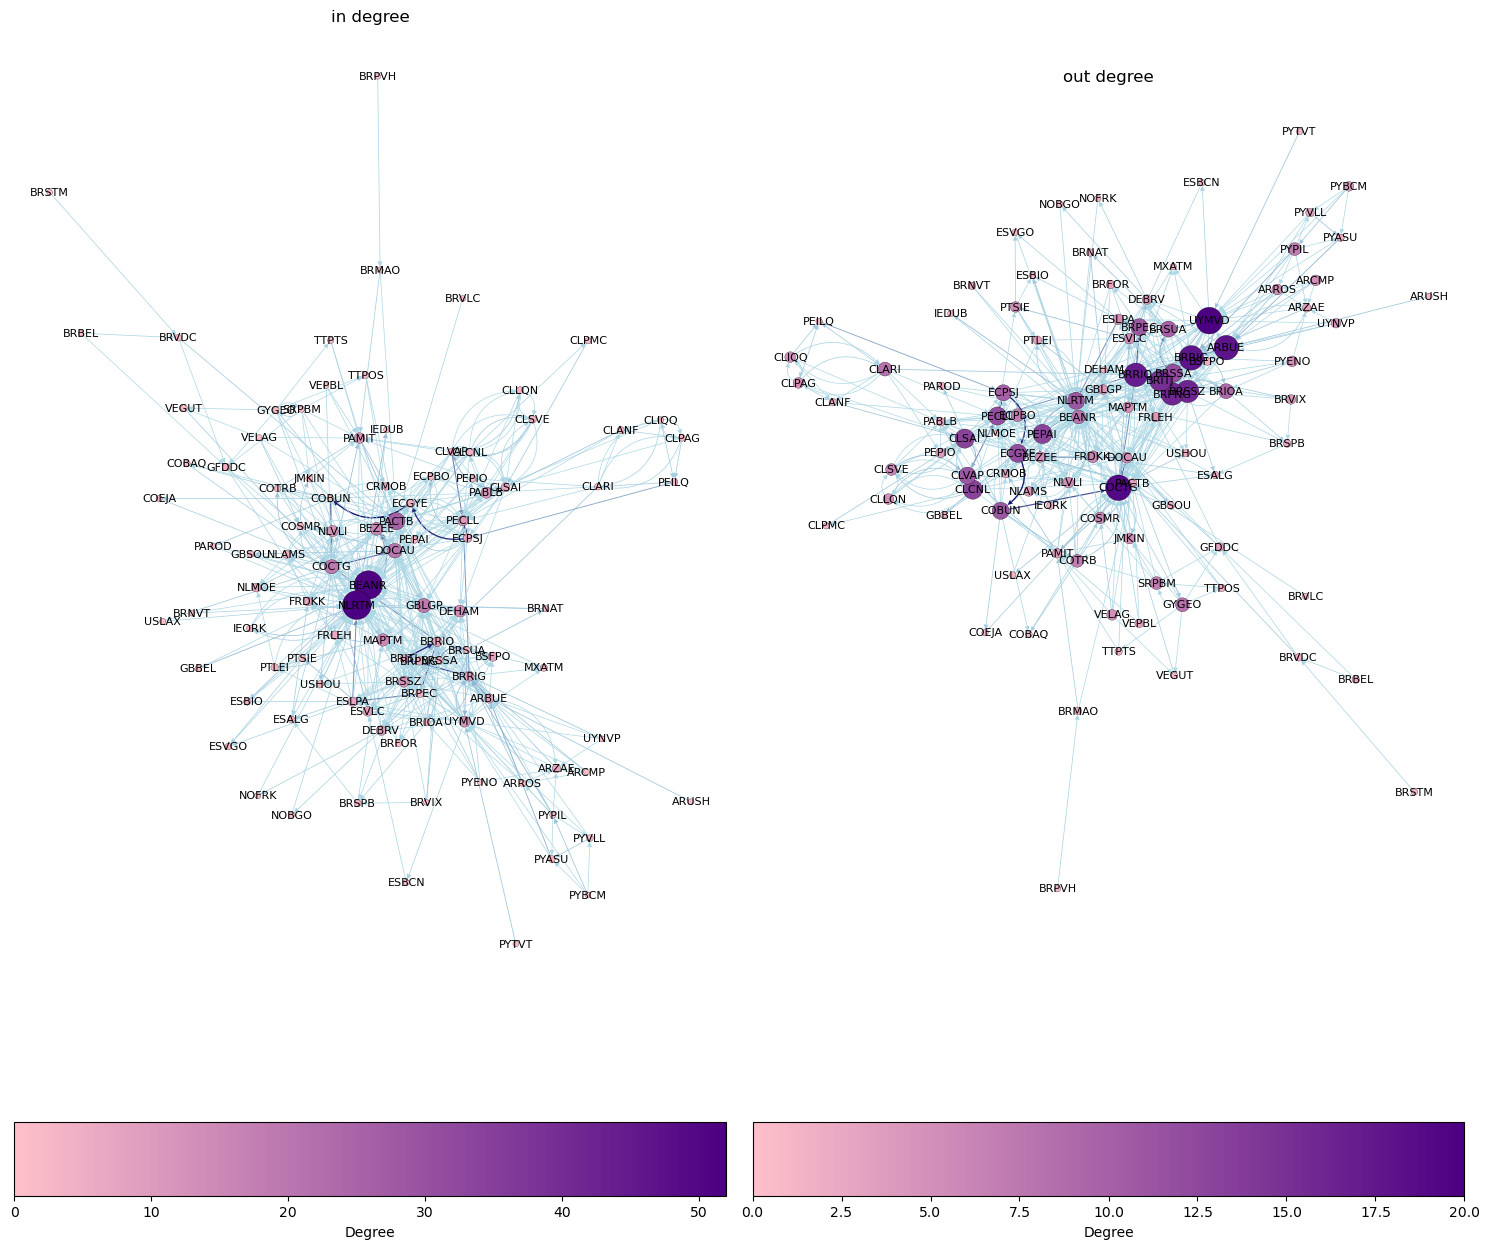

In [34]:
fig, axs = plt.subplots(
    2, 2,
    figsize=(15, 15),
    gridspec_kw=dict(height_ratios=(20, 1)),
)

plot_degree(ig_G, in_degree, "in degree", *axs[:, 0])
plot_degree(ig_G, out_degree, "out degree", *axs[:, 1])
fig.tight_layout(h_pad=1)
plt.savefig("./figure/degree_SA_msc_route.png")
plt.show()